In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoTokenizer, AutoModel
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import torch
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import string

In [3]:
df = pd.read_csv('Topic data.csv')
df

,filename,content,SOM,location,call_duration,Ariadne_internal_ID
0,SOM_118_00513_FA163E622DEB-1a7e-e29da700-832c3...,Herzlich willkommen bei O sein uns am Apparat ...,SOM,118,513,FA163E622DEB-1a7e-e29da700-832c3-64e3520f-7cef...
1,SOM_118_00513_FA163E52FD32-1a7e-2da87700-aa52c...,Willkommen bei der O Kundenbetreuung sie sprec...,SOM,118,513,FA163E52FD32-1a7e-2da87700-aa52c-64e76b65-aec3...
2,SOM_118_00513_FA163ED88855-1b1d-62522700-9f3ab...,Herzlich Willkommen hier ist die DSL und Techn...,SOM,118,513,FA163ED88855-1b1d-62522700-9f3ab-64e5fe14-2206...
3,SOM_118_00514_FA163E622DEB-1a7e-e61e1700-87f84...,Hallo schönen guten Tag herzlich willkommen be...,SOM,118,514,FA163E622DEB-1a7e-e61e1700-87f84-64e5d698-d607...
4,SOM_118_00259_FA163E52FD32-1a7e-2da87700-a5517...,Willkommen bei O so langsam Apparat\nEs ging e...,SOM,118,259,FA163E52FD32-1a7e-2da87700-a5517-64e5eed0-89ea...
...,...,...,...,...,...,...
64530,SOM_VYD_-0001_FA163E56E95C-5e28-26ff4700-25e26...,Können sie mich hören hallo ja hallo ich habe ...,SOM,VYD,-1,FA163E56E95C-5e28-26ff4700-25e26-64e8d8b1-9987...
64531,SOM_VYD_-0001_FA163E52FD32-1a7e-3028c700-7a142...,Wunderschönen guten Tag und herzlich willkomme...,SOM,VYD,-1,FA163E52FD32-1a7e-3028c700-7a142-64e46468-1225...
64532,SOM_VYD_-0001_FA163E622DEB-1a7e-e41dd700-88d9b...,Ja hallo mein Name ist Ari guten sie mit so un...,SOM,VYD,-1,FA163E622DEB-1a7e-e41dd700-88d9b-64e70e8f-3d3a...
64533,SOM_VYD_-0001_FA163E44569D-1a89-b144b700-8492d...,Herr Müller sehr guten tag die Kollegin hat mi...,SOM,VYD,-1,FA163E44569D-1a89-b144b700-8492d-64e70077-5731...


In [25]:
# Frequency counts for categorical columns
location_counts = df['location'].value_counts()

location_counts


location
VYD    15508
TPF     9448
LUB     5033
SKO     4917
CCX     4896
EPO     3990
CHS     3743
SLF     3339
CHO     2908
SJJ     2856
135     2140
CDA     1188
138      996
POT      892
AMV      861
141      573
118      444
NBS      388
NUE      344
SZW       71
Name: count, dtype: int64

In [26]:
som_counts = df['SOM'].value_counts()
som_counts

SOM
SOM    64535
Name: count, dtype: int64

In [23]:
df.describe()

,call_duration
count,64535.000000
mean,532.614132
std,2872.453512
min,-2693.000000
25%,224.000000
50%,405.000000
75%,690.000000
max,720346.000000


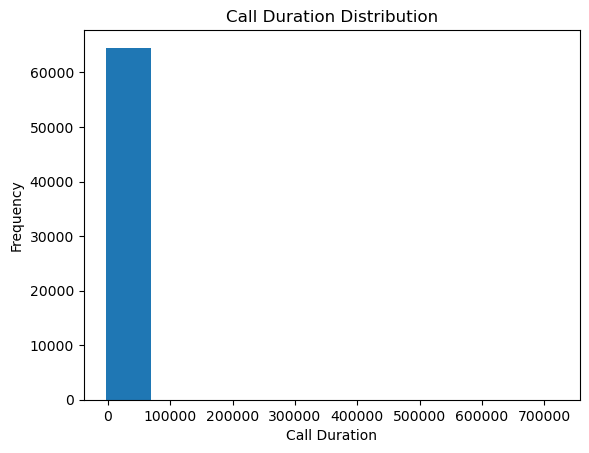

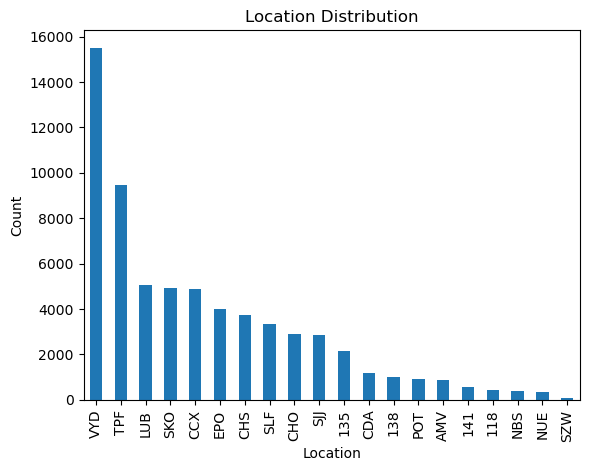

In [21]:


# Histogram for call_duration
plt.hist(df['call_duration'])
plt.xlabel('Call Duration')
plt.ylabel('Frequency')
plt.title('Call Duration Distribution')
plt.show()

# Bar chart for location counts
location_counts.plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Location Distribution')
plt.show()


In [3]:
# Load the spaCy German language model
nlp = spacy.load('de_core_news_sm')
# Create an empty list to store the updated text without proper names
updated_texts = []
# Iterate over the text column and remove proper names using spaCy
for text in df['content']:
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.pos_ != 'PROPN':
            tokens.append(token.text)
    updated_texts.append(' '.join(tokens))
# Update the 'text' column with the modified text
df['content'] = updated_texts

# Print the updated dataset
df.head()

,filename,content,SOM,location,call_duration,Ariadne_internal_ID
0,SOM_118_00513_FA163E622DEB-1a7e-e29da700-832c3...,Herzlich willkommen bei sein uns am Apparat wa...,SOM,118,513,FA163E622DEB-1a7e-e29da700-832c3-64e3520f-7cef...
1,SOM_118_00513_FA163E52FD32-1a7e-2da87700-aa52c...,Willkommen bei der Kundenbetreuung sie spreche...,SOM,118,513,FA163E52FD32-1a7e-2da87700-aa52c-64e76b65-aec3...
2,SOM_118_00513_FA163ED88855-1b1d-62522700-9f3ab...,hier ist die und Technik Abteilung ich bräucht...,SOM,118,513,FA163ED88855-1b1d-62522700-9f3ab-64e5fe14-2206...
3,SOM_118_00514_FA163E622DEB-1a7e-e61e1700-87f84...,schönen guten Tag herzlich willkommen bei ihne...,SOM,118,514,FA163E622DEB-1a7e-e61e1700-87f84-64e5d698-d607...
4,SOM_118_00259_FA163E52FD32-1a7e-2da87700-a5517...,Willkommen bei so langsam Apparat \n Es ging e...,SOM,118,259,FA163E52FD32-1a7e-2da87700-a5517-64e5eed0-89ea...


In [8]:
# Download the NLTK stop words list and wordnet for lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Snowball stemmer and WordNet lemmatizer
stemmer = SnowballStemmer("german")  # Use the appropriate language for stemming
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('german'))  # Use the appropriate language
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove short words (length < 3 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Lemmatize or stem the words
    # Uncomment one of the following lines based on your choice
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the preprocessing function to the DataFrame
df['content'] = df['content'].apply(preprocess_text)

# Print the cleaned DataFrame
print(df['content'])


[nltk_data] Downloading package stopwords to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0        herzlich willkomm apparat tun muss mal guck ko...
1        willkomm kundenbetreu sprech maximilian nikola...
2        herzlich willkomm dsl technik abteil braucht k...
3        hallo schon gut tag herzlich willkomm protoser...
4        willkomm langsam apparat ging halt rahm suppor...
                               ...                        
64530    hor hallo hallo gerad kolleg gesproch weiterge...
64531    wunderschon gut tag herzlich willkomm ausgezei...
64532    hallo nam ari gut wurd weitergeleitet indizier...
64533    herr mull gut tag kollegin gesagt problem rout...
64534    herr schreib nam nicola tun hallo person kunde...
Name: content, Length: 64535, dtype: object


In [12]:
# Words to remove
words_to_remove = ['bitt', 'mal', 'schon', 'genau', 'dank', 'gut', 'tag', 'numm', 'person', 'kurz', 
                   'einfach', 'neu', 'schau', 'moment', 'sag', 'muss', 'geht', 'fall', 'ganz', 'war', 'gern', 'frag', 
                   'gleich',
                  'guck', 'imm', 'halt', 'wurd', 'seh', 'natur', 'quasi', 'gerad', 'bekomm', 'rout', 'gesagt', 'nein', 
                   'tun', 'syst',
                  'mehr', 'mocht', 'box', 'geh', 'zugangsdat', 'passwort', 'kennwort', 'steht','seit', 'klein', 'bekomm', 'rufnumm', 
                   'kundenkennzahl', 'leid', 'tun', 'nam', 'per', 'willkomm', 'herzlich', 'gemacht', 'bleib', 'herr',
                   'kolleg',
                   'schick', 'frau', 'geb', 'richtig', 'vielleicht', 'viel','kart', 'brot', 'brauch',
                  'erst', 'gibt', 'kommt', 'moglich',  'pro', 'iphon', 'sekund', 'minut', 'wirklich', 'krieg',
                   'tatsach', 'musst', 'weiss',  'darf', 'find', 'gar', 'probl' , 'nee', 'klar', 'tschuss', 'heut', 'uhr', 'anruf', 
                   'wunsch', 'dat' , 'hallo', 'kundig']

# Function to remove specified words from text
def remove_specific_words(text):
    # Tokenize the text
    tokens = text.split()
    
    # Filter out words to remove
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    
    # Join the remaining tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

# Apply the function to the 'cleaned_text' column
df['content'] = df['content'].apply(remove_specific_words)

# Print the cleaned DataFrame
df['content']


0        apparat konto sau aktuell stand ding gemeldet ...
1        kundenbetreu sprech maximilian nikolaus storni...
2        dsl technik abteil braucht kundennumm abgleich...
3        protoservic labitar motor internet haus funkti...
4        langsam apparat ging rahm support kund gemeins...
                               ...                        
64530    hor gesproch weitergeleitet desweg myhom myhom...
64531    wunderschon ausgezeichnet wichtig technik schm...
64532    ari weitergeleitet indiziert adress postleitza...
64533    mull kollegin problem korrekt fehlermeld verst...
64534    schreib nicola worum rechnung ruf handynumm fo...
Name: content, Length: 64535, dtype: object

In [13]:
# Step 1: Topic Modeling (LDA)
# Convert text data to a document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['content'])



In [14]:
# Apply LDA for topic modeling
num_topics = 7  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
def get_top_words(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_word_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [words[i] for i in top_word_idx]
        topics[f"Topic {topic_idx + 1}"] = top_words
    return topics

topics = get_top_words(lda, vectorizer)
print("Top words for each topic:")
for topic, top_words in topics.items():
    print(f"{topic}: {', '.join(top_words)}")

Top words for each topic:
Topic 1: sms, bewert, storung, sup, gesprach, weit, uberpruf, best, weiterhelf, wart
Topic 2: internet, wlan, fritz, dsl, kabel, leitung, verbind, funktioniert, hom, spot
Topic 3: sms, formular, handy, link, alt, vertrag, eben, blau, gerat, portier
Topic 4: technik, adress, termin, dsl, leitung, anschluss, strass, umzug, telekom, vertrag
Topic 5: vertrag, rechnung, kundennumm, monat, august, versteh, end, letzt, bestat, gekundigt
Topic 6: tarif, sms, vertrag, handy, monat, eigent, angebot, sup, beispiel, rein
Topic 7: monat, vertrag, tarif, rabatt, angebot, handy, jahr, preis, weit, kostet
